In [1]:
#Config
from pyspark import SparkConf, SparkContext, HiveContext
import re
import numpy as np
import pandas as pd
import datetime

In [2]:
sc.stop()
conf = SparkConf().set("spark.executor.instances", 32).set("spark.driver.maxResultSize", "8g")
sc = SparkContext(conf=conf)
hc = HiveContext(sc)

In [3]:
# Cyrrilic -> Latin
symbols = (u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
           u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")

tr = {ord(a):ord(b) for a, b in zip(*symbols)}

In [36]:
#Read data
dfr = pd.read_csv('./data/result_Card_21.csv',sep=';')
df1 = pd.get_dummies(dfr[[u'open', u'click', u'abuse', u'unsubscribe', u'error']])
df1.columns = [c.decode('utf-8').translate(tr).replace(' ','_') for c in df1.columns]
df1['email'] = dfr['email']
df1 = df1.rename(columns = {       u'abuse':u'abuse',
                               u'open_open': u'open',
                             u'click_click': u'click',
                 u'unsubscribe_unsubscribe': u'unsubscribe',
                    u'error_Jaloba_na_spam': u'err_spam',
       u'error_Poctovyj_asik_ne_susestvuet': u'err_not_exists',
           u'error_Poctovyj_asik_neaktiven': u'err_not_active',
                                   u'email':u'email'})
df1[[  u'open',u'click',  u'unsubscribe',   u'err_spam', u'err_not_exists',u'err_not_active']] = \
df1[[  u'open',u'click',  u'unsubscribe',   u'err_spam', u'err_not_exists',u'err_not_active']].astype(int)

In [37]:

hc.sql('drop table if exists deliv_res_temp1')
hc.registerDataFrameAsTable(hc.createDataFrame(df1), 'deliv_res_temp1')
hc.sql('drop table if exists user_kposminin.delivery_results2')
hc.sql('create table user_kposminin.delivery_results2 as select * from deliv_res_temp')


"\nhc.sql('drop table if exists deliv_res_temp1')\nhc.registerDataFrameAsTable(hc.createDataFrame(df1), 'deliv_res_temp1')\nhc.sql('drop table if exists user_kposminin.delivery_results2')\nhc.sql('create table user_kposminin.delivery_results2 as select * from deliv_res_temp')\n"

In [38]:
process_query = '''
drop table if exists user_kposminin.delivery_results3;

create table user_kposminin.delivery_results3 as 
select 
   d.*,
   not (t.email is NULL) as control,
   s.model,
   s.score,
   not (pa.utm_term is NULL) as started,
   eu.utm_term,
   (pa.is_processed = 3) as completed

from 
   user_kposminin.delivery_results2 d
left join (select `_1` as email from user_mvsurovikov.la_cc_emails_hashed_ctrl_20160809) t
    on d.email = t.email
left join
     (select 
        email,
        model,
        max(score) as score
      from
        user_mvsurovikov.la_cc_scored_20160809_3
      group by 
        email,
        model
      ) s
     on
      d.email = s.email
left join
    (select 
        `_1` as email,
        `_2` as utm_term
    from
        (
        select * from user_mvsurovikov.la_cc_emails_hashed_ctrl_20160809 
        union all
        select * from user_mvsurovikov.la_cc_emails_hashed_20160809 
        ) a
    ) eu
    on d.email = eu.email
left join prod_dds.portal_application pa 
    on eu.utm_term = pa.utm_term'''

#for q in process_query.split(';'):
#    hc.sql(q)




In [4]:
df = pd.DataFrame([r.asDict() for r in hc.sql('select * from user_kposminin.delivery_results3').collect()])

In [5]:
for c in df.columns:
    if df[c].dtype == type(True): df[c] = df[c].astype(int)

In [6]:
df1 = df[(df['model'].notnull() & (~df['control']))|(df['model'].isnull() & (df['control']))]
df1['model'] = df1[['control','model']].apply(lambda (c,m): 'control' if c else m, 1)
df1 = df1[df1['err_not_active'] + df1['err_not_exists'] ==0]
df1['completed'] = df1['completed'].apply(lambda c:  0 if pd.isnull(c) else  1 * c)
df2 = df1.groupby(['email','model']).max().reset_index()
#df2[df2.groupby(['email','model'])['control'].transform(np.size)>1] # check for duplicates
#df1[['err_not_active','err_not_exists','err_spam','completed','open','click']].drop_duplicates()

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [341]:
#df1[(df1['control'] == 0)][['completed','email']].drop_duplicates().count()
#df1[['model','control']].drop_duplicates()
m = 'filkos'
#dfm = df1[df['model'] == m]
#print(df1[['model','email','completed']].drop_duplicates().groupby('model')['completed'].mean())
print(df1[(df1['model']!='control')&(df1['model']!='creur_cc')&(df1['model']!='mkb_cc')&(df1['model']!='bankcreditcard') \
    &(df1['model']!='rsb_cc')&(df1['model']!='cashalot')&(df1['model']!='filkos')][['email','completed']].drop_duplicates()['completed'].mean())

0.0016335840217


In [7]:
print(df1[['model','email','completed']].drop_duplicates().groupby('model')['completed'].mean())

model
bankcreditcard    0.001729
cashalot          0.002169
control           0.000462
creur_cc          0.001702
filkos            0.001652
mkb_cc            0.001580
raif_cc           0.001634
rsb_cc            0.002107
Name: completed, dtype: float64


In [8]:
# Marking missing values in open and click
#df1[['open','click']] = df1[['open','click','started','completed']].apply( lambda (o,c,s,comp): (max(o,c,s,comp), max(c,s,comp)), 1)
df1['open'] = df1[['open','click','started','completed']].apply( lambda (o,c,s,comp): max(o,c,s,comp), axis = 1)
df1['click'] = df1[['click','started','completed']].apply( lambda (c,s,comp): max(c,s,comp), axis = 1)

In [9]:
print(df1.groupby('model')['completed'].mean())

model
bankcreditcard    0.001728
cashalot          0.002169
control           0.000462
creur_cc          0.001702
filkos            0.001651
mkb_cc            0.001579
raif_cc           0.001633
rsb_cc            0.002107
Name: completed, dtype: float64


In [12]:
df2 = df1.groupby(['email','model']).max().reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92aac61810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f92b8802490>]], dtype=object)

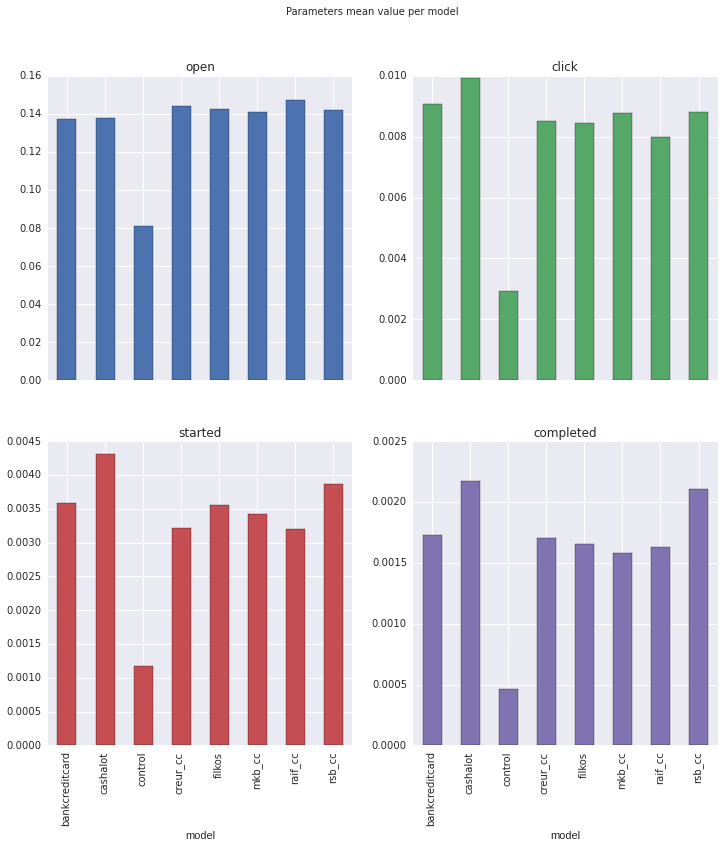

In [150]:
 %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df1.groupby('model')['open','click','started','completed'].mean() \
    .plot(kind = 'bar', subplots = 1, layout = (2,2), legend = False, figsize = (12,12), title = 'Parameters mean value per model' )

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


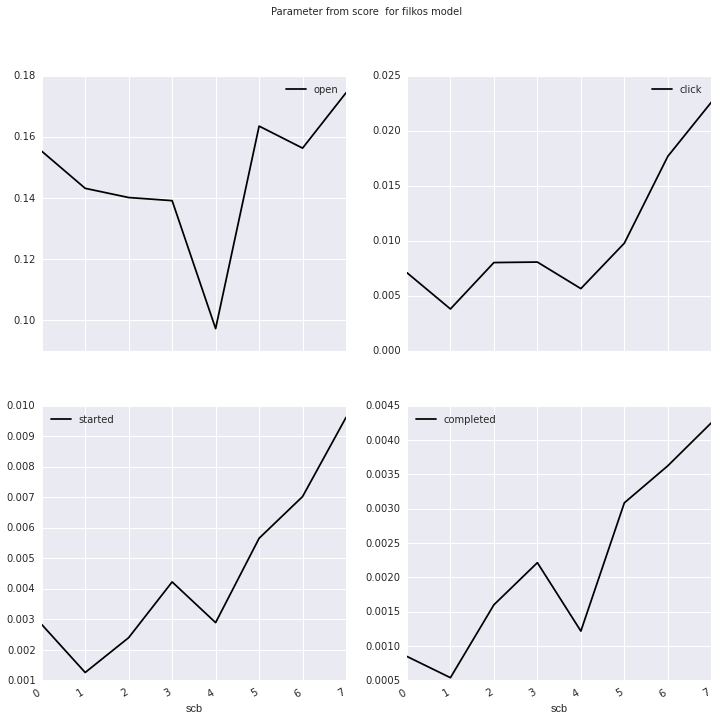

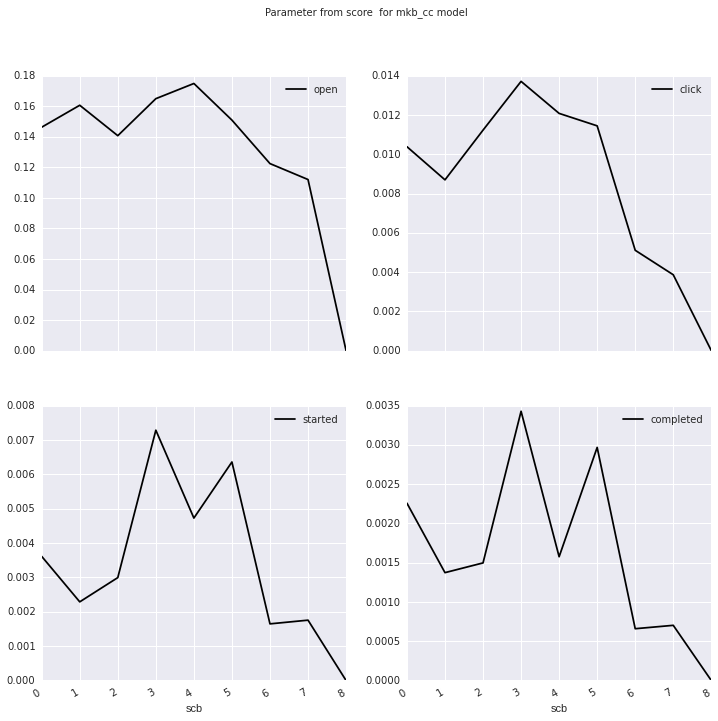

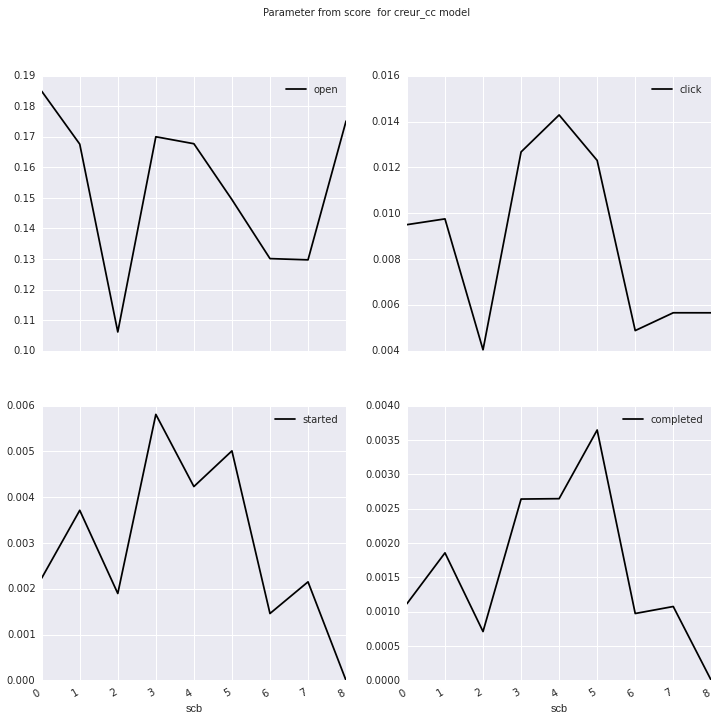

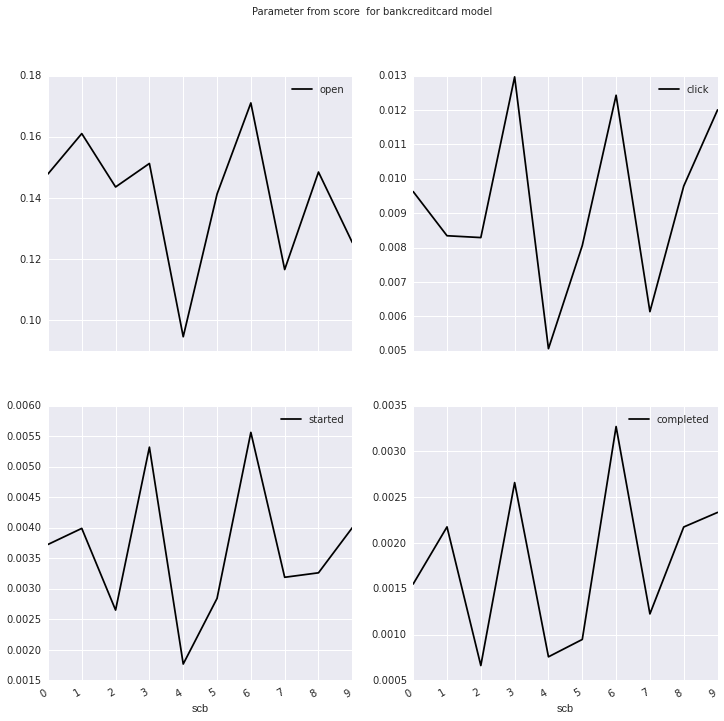

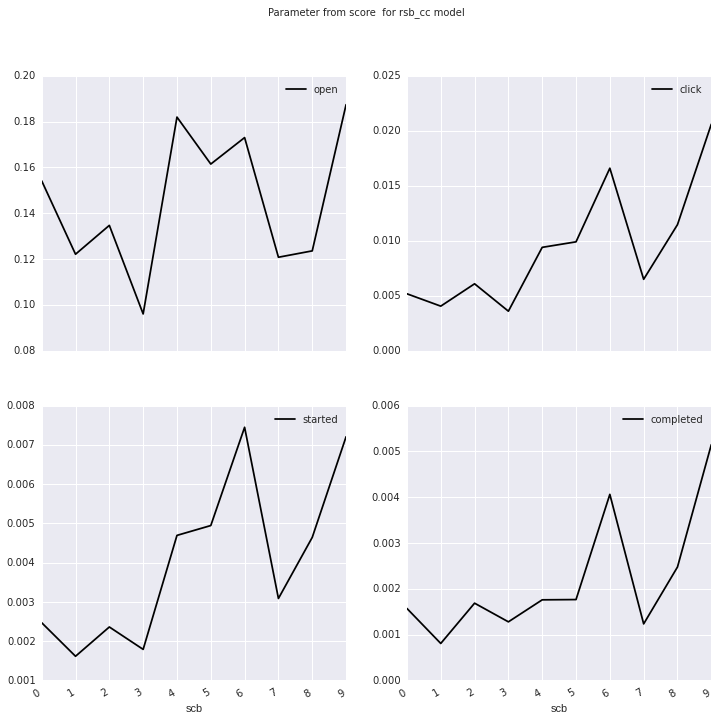

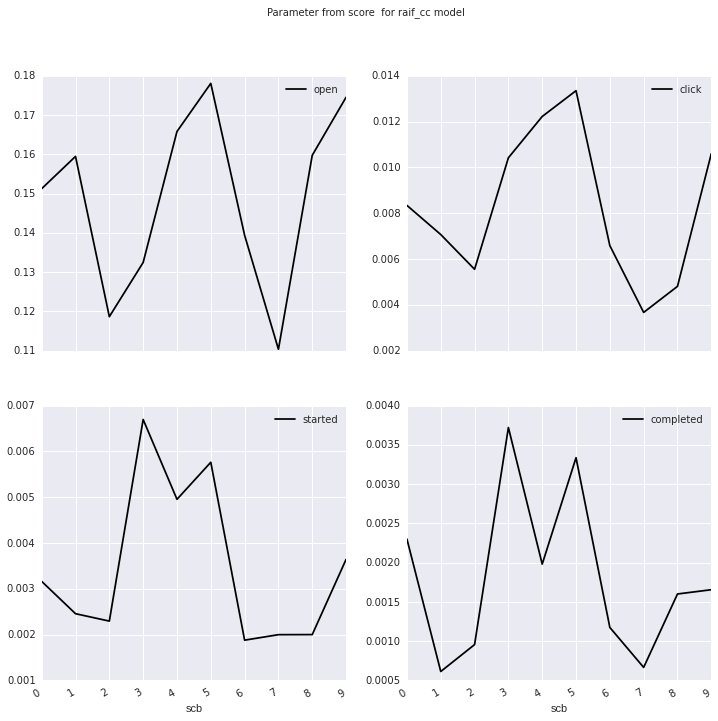

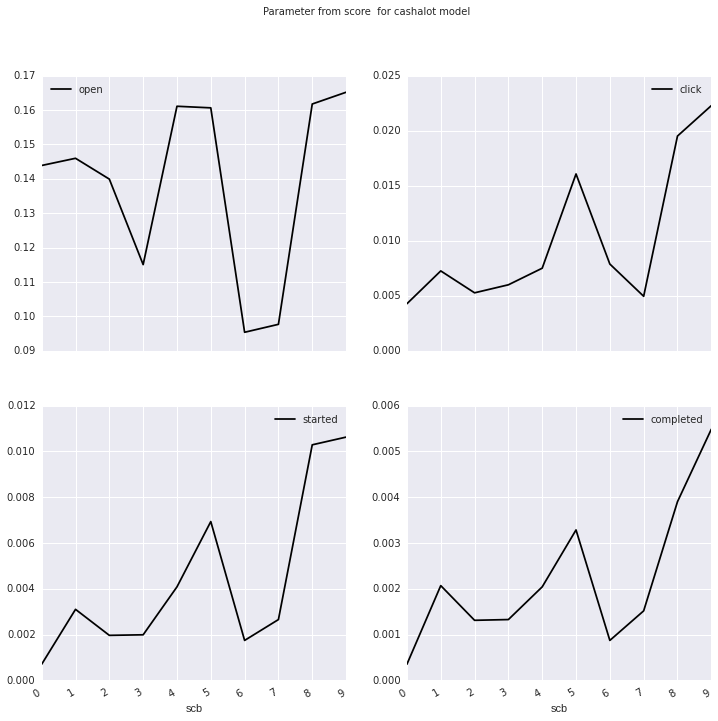

In [161]:
for model in df1['model'].unique():
    if model!= 'control':
        dfm = df1[df1['model'] == model]
        dfm.loc[:,'scb'] = pd.cut(dfm['score'], bins = np.unique(dfm['score'].quantile(np.arange(0,1.1,0.1)).values), labels  = False).values
        dfm.groupby('scb')['open','click','started','completed'].mean() \
            .plot(subplots = 1, layout = (2,2) , title  = 'Parameter from score  for ' + model + ' model', figsize = (12,12))
        #print('-' * 100)

In [220]:
import scipy
pval = {}
for param in ['open','click','started','completed']:
    pval[param] = {}
    table = df1.groupby('model')[param].agg({'pos':sum,'neg':lambda a: len(a) - sum(a)})
    for model in df1['model'].unique():
        if model!= 'control':
            pval[param][model] = scipy.stats.fisher_exact(table.loc[[model,'control']].T.values, alternative='less')[1]


In [243]:
pval = pd.DataFrame(pval)
print("p-values of parameter distribution equality for model and control samples.\n")
print(pval)


p-values of parameter distribution equality for model and control samples.

                       click     completed           open       started
bankcreditcard  8.375660e-23  2.125493e-06  4.203499e-106  9.693207e-10
cashalot        3.204280e-27  5.014556e-09  3.019879e-106  1.445282e-13
creur_cc        4.736275e-17  1.631661e-05  1.308376e-106  8.075822e-07
filkos          2.379336e-22  1.280100e-06  8.934372e-143  1.002090e-10
mkb_cc          4.876820e-19  4.364940e-05  1.187513e-103  4.844589e-08
raif_cc         9.537560e-18  5.556830e-06  3.161351e-145  5.499258e-08
rsb_cc          5.216436e-21  1.532854e-08  2.230515e-118  5.529527e-11


In [248]:
pvalsc = {}

for param in ['open','click','started','completed']:
    pvalsc[param] = {}
    for model in df1['model'].unique():
        if model!= 'control':
            dfm = df1[df1['model'] == model]
            q25,q75 = dfm['score'].quantile([0.25,0.75])
            pvalsc[param][model] = scipy.stats.fisher_exact([
                    [
                        dfm[dfm['score'] <=q25][param].sum(),
                        dfm[dfm['score'] >=q75][param].sum()
                    ],
                    [
                        dfm[dfm['score'] <=q25][param].count() - dfm[dfm['score'] <=q25][param].sum(),
                        dfm[dfm['score'] >=q75][param].count() - dfm[dfm['score'] >=q75][param].sum()
                    ]
                ],alternative='less')[1]
            


In [253]:
pvalsc = pd.DataFrame(pvalsc)
print("\np-values of score inefficiency: exact fisher test for upper and lower quartiles.\n")
print(pvalsc.applymap(lambda v:'{0:.4f} '.format(v)))


p-values of score inefficiency: exact fisher test for upper and lower quartiles.

                  click completed     open  started
bankcreditcard  0.6534    0.4942   1.0000   0.7455 
cashalot        0.0000    0.0016   0.4396   0.0000 
creur_cc        0.9988    0.8966   1.0000   0.9836 
filkos          0.0000    0.0000   0.5030   0.0000 
mkb_cc          1.0000    0.9794   1.0000   0.9951 
raif_cc         0.9265    0.7733   0.9737   0.8913 
rsb_cc          0.0001    0.1409   0.9975   0.0386 


** Вывод. **

Использование моделей позволяет значимо повысить эффективность рассылки по всем показателям: 
- доля открывших письмо, 
- доля кликнувших,
- доля начавших заполнять заявку
- доля заполнивших заявку.

Эффективность моделей приблизительно на одном уровне с небольшим преимуществом cashalot, rsb_cc, лидирующих по доле начавших и закончивших заполнение заявки, а также эффективному ранжированию по скору.
Скоринг не ранжирует эффективно для моделей mkb_cc, creur_cc, raif_cc.


In [20]:
df3

,models_num,sample_size,completed_sum,completed_mean
0,1,42129,34,0.000807
1,2,20810,34,0.001634
2,3,15948,12,0.000752
3,4,14412,36,0.002498
4,5,24935,75,0.003008
5,6,16914,36,0.002128
6,7,73465,147,0.002001


In [21]:
dfm = df2[df2['model']!='control']
dfm['models_num'] = dfm.groupby('email')['control'].transform(np.size)
df3 = dfm.groupby('models_num')['completed'].agg({'completed_sum':np.sum,'sample_size':np.size, 'completed_mean':np.mean}).reset_index()

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [22]:
v = []
cumsum=0
cumcount=0
lost = 0
totalsum = df3['completed_sum'].sum()
for (num,count1,sum1,mean1) in df3[[u'models_num', u'sample_size', u'completed_sum', u'completed_mean']].values[::-1]:
    cumsum += sum1/num
    cumcount += count1/num
    v.append([num,sum1/num,count1/num,mean1,cumsum,cumcount,cumsum/cumcount])
    #lost = sum1/num
print('\nCompleted stats for samples from several models intersection.\n')
print(pd.DataFrame(v,columns = (['models count','completed','sample_size','completed_ratio','cumul_completed',
         'cumul_sample_size','cumul_completed_ratio'])) \
    .sort('models count').reset_index(drop = True))


Completed stats for samples from several models intersection.

   models count  completed  sample_size  completed_ratio  cumul_completed  \
0             1         34        42129         0.000807              106   
1             2         17        10405         0.001634               72   
2             3          4         5316         0.000752               55   
3             4          9         3603         0.002498               51   
4             5         15         4987         0.003008               42   
5             6          6         2819         0.002128               27   
6             7         21        10495         0.002001               21   

   cumul_sample_size  cumul_completed_ratio  
0              79754               0.001329  
1              37625               0.001914  
2              27220               0.002021  
3              21904               0.002328  
4              18301               0.002295  
5              13314               0.002028